In [2]:
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parameter as Parameter
import time
import random
import torchvision
import torchvision.transforms as transforms
from pathlib import Path
import matplotlib.pyplot as plt
import csv
import os
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  1.13.0
Torchvision Version:  0.14.0


In [4]:
folder = r'./stochastic_1_1'

net_fn = os.path.join(folder, 'binarized_net.pt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device type:", device)

batch_size = 50 # the original paper use batch size of 50 on CIFAR-10

device type: cuda


In [6]:
transform = transforms.Compose(
  [transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def hard_sigmoid(x):
  return torch.clamp((x+1)/2, 0, 1) # The clip function

def binarize(W, binary="stochastic"):
  if binary == "stochastic": # Stochastic binarization
    sigma = hard_sigmoid(W)
    Wb = torch.distributions.binomial.Binomial(total_count=1, probs=sigma).sample()
    Wb = torch.where(Wb==0, torch.tensor(-1., device=device), torch.tensor(1., device=device)) # If we want to binarize the network with 0 and 1, we can delete this line
  elif binary == "deterministic": # Deterministic binarization with 1 and -1
    Wb = torch.where(W >= 0, torch.tensor(1., device=device), torch.tensor(-1., device=device)) # https://pytorch.org/docs/stable/generated/torch.where.html
    # Wb = torch.where(W >= 0.5, torch.tensor(1., device=device), torch.tensor(0, device=device)) # Deterministic binarization with 1 and 0
  else:
    Wb = W
  return Wb

In [8]:
class binConv2d(nn.Conv2d):
  def __init__(self, *kargs, **kwargs):
    super(binConv2d, self).__init__(*kargs, **kwargs)
  
  def forward(self, input):
    if not hasattr(self.weight, 'org'):
      self.weight.org = self.weight.data.clone()
    self.weight.data = binarize(self.weight.org, binary="stochastic")
    output = nn.functional.conv2d(input, self.weight, None, self.stride, self.padding, self.dilation, self.groups)
    return output

class binLinear(nn.Linear):
  def __init__(self, *kargs, **kwargs):
    super(binLinear, self).__init__(*kargs, **kwargs)
  
  def fowward(self, input):
    if not hasattr(self.weight, 'org'):
      self.weight.org=self.weight.data.clone()
    self.weight = binarize(self.weight.org, binary="stochastic")
    output = nn.functional.linear(input, self.weight, None)
    return output

In [9]:
class BinaryNet(nn.Module):
  def __init__(self):
    super(BinaryNet, self).__init__()
    self.features = nn.Sequential(
        binConv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=128, affine=False),
        # nn.BatchNorm2d(num_features=128, affine=True),
        nn.ReLU(),
        binConv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=128, affine=False),
        # nn.BatchNorm2d(num_features=128, affine=True),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        binConv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=256, affine=False),
        # nn.BatchNorm2d(num_features=256, affine=True),
        nn.ReLU(),
        binConv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=256, affine=False),
        # nn.BatchNorm2d(num_features=256, affine=True),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        binConv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512, affine=False),
        # nn.BatchNorm2d(num_features=512, affine=True),
        nn.ReLU(),
        binConv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512, affine=False),
        # nn.BatchNorm2d(num_features=512, affine=True),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        binConv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=1024, affine=False),
        # nn.BatchNorm2d(num_features=1024, affine=True),
        nn.ReLU(),
        binConv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=1024, affine=False),
        # nn.BatchNorm2d(num_features=1024, affine=True),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    )
    self.classifiers = nn.Sequential(
        binLinear(4096, 1024),
        nn.BatchNorm1d(1024, affine=False),
        # nn.BatchNorm1d(1024, affine=True),
        binLinear(1024, 10),
        nn.BatchNorm1d(10, affine=False),
        # nn.BatchNorm1d(10, affine=True),
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.shape[0], -1)
    x = self.classifiers(x)
    return x

In [10]:
def init_weight(layer): # https://pytorch.org/docs/stable/nn.init.html
  if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
    torch.nn.init.uniform_(layer.weight, a=0, b=1)
    # torch.nn.init.normal_(tensor=layer.weight, mean=0.5, std=1)

In [11]:
# criterion = nn.HingeEmbeddingLoss(size_average=True)
criterion = nn.CrossEntropyLoss()
num_epochs = 500
LR_start = 3 * 1e-3
LR_fin = 2 * 1e-6
LR_decay = (LR_fin/LR_start)**(1./num_epochs)
LR = LR_start
net = BinaryNet()
# net.apply(fn=init_weight) # init weight for weight of +1 and 0
print("num_epochs:", num_epochs, " learning_rate_start:", LR_start, " learning_rate_final:", LR_fin, " learning_rate_decay:", LR_decay)
print(net)
net = net.to(device)

num_epochs: 500  learning_rate_start: 0.003  learning_rate_final: 2e-06  learning_rate_decay: 0.9854800059995851
BinaryNet(
  (features): Sequential(
    (0): binConv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): binConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): binConv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (9): ReLU()
    (10): binConv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool

In [12]:
def validate_model(model, dataloader, n = None):
    
    # Set to evaluation mode rather than training mode
    model.eval()

    top1 = 0
    total = 0

    # Iterate over data stopping early if n is set
    for i, (inputs, labels) in enumerate(dataloader):
        if (n is not None and i >= n):
            break
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Run the model and collect the top 1 outputs.
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        # Gather statistics
        top1 += torch.sum(predicted == labels.data)
        total += len(outputs)

    top1_acc = 100 * top1.double() / total
    return top1_acc

In [13]:
# def calculate_the_rate_of_0_in_layers(model):
#   the_rate_of_0_list = []
#   for layer in model.features:
#     if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
#       the_rate_of_0_list.append(1 - torch.mean(layer.weight).detach().cpu().numpy())

#   for layer in model.classifiers:
#     if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
#       the_rate_of_0_list.append(1 - torch.mean(layer.weight).detach().cpu().numpy())
#   return the_rate_of_0_list

# def calculate_the_rate_of_0_in_gradients(model):
#   the_rate_of_0_list = []
#   for layer in model.features:
#     if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
#       print(layer.weight.grad)
#       the_rate_of_0_list.append(1 - (torch.count_nonzero(layer.weight.grad) / torch.numel(layer.weight.grad)).detach().cpu().numpy())

#   for layer in model.classifiers:
#     if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
#       print(layer.weight.grad)
#       the_rate_of_0_list.append(1 - (torch.count_nonzero(layer.weight.grad) / torch.numel(layer.weight.grad)).detach().cpu().numpy())
#   return the_rate_of_0_list

def calculate_the_magnitude_of_gradients(model):
  the_magnitude_of_gradients = []
  for layer in model.features:
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
      # print(layer.weight.grad)
      the_magnitude_of_gradients.append(torch.mean(torch.abs(layer.weight.grad)).detach().cpu().numpy())

  for layer in model.classifiers:
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
      # print(layer.weight.grad)
      the_magnitude_of_gradients.append(torch.mean(torch.abs(layer.weight.grad)).detach().cpu().numpy())
  return the_magnitude_of_gradients

In [14]:
if Path(net_fn).is_file():
  net.load_state_dict(torch.load(net_fn)) # load file if previously executed
  print("Skipped Training. Loaded network")
else:
  train_loss_of_every_epoch = []
  validation_accuracy_of_every_epoch = []

  for epoch in range(num_epochs):
    running_loss = 0.0
    running_num = 0
    optimizer = torch.optim.Adam(net.parameters(), lr=LR)

    for i, data in enumerate(trainloader, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = net(inputs) # forward

      loss = criterion(outputs, labels) # calculate loss.
      loss.backward() # Use binarized weights to compute derivatives to speed up.

      for p in list(net.parameters()):
        if hasattr(p,'org'):
          p.data.copy_(p.org)

      optimizer.step() # Use derivatives to update original weights rather than binarized weights.

      for p in list(net.parameters()):
        if hasattr(p,'org'):
          p.org.copy_(p.data.clamp_(-1, 1))

      # for p in list(net.parameters()):
      #   p.data = p.data.clamp_(-1, 1)

      running_loss += loss.item()
      running_num += batch_size

    
    # print("eopch: ", epoch+1, ", the magnitude of gradients: ", calculate_the_magnitude_of_gradients(model=net))
      
    print("eopch: ", epoch+1, ", learning rate: ", LR)
    LR = LR * LR_decay
    
    print("eopch: ", epoch+1, ", training loss: ", running_loss / running_num)
    train_loss_of_every_epoch.append(running_loss / running_num)

    top1_acc = validate_model(net, testloader)
    print("eopch: ", epoch+1, ", accuracy: ", top1_acc)
    validation_accuracy_of_every_epoch.append(top1_acc.detach().cpu().numpy())
    
  torch.save(net.state_dict(), net_fn)
  with open(os.path.join(folder, 'train_loss_and_validation_accuracy.csv'), 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    writer.writerow(train_loss_of_every_epoch)
    writer.writerow(validation_accuracy_of_every_epoch)

  print('Finished Training. Saved network')

Skipped Training. Loaded network


Skipped Training. Loaded network trained by stochastic binarization with binarizer being 1 and -1
Skipped Training. Loaded network trained by deterministic binarization with binarizer being 1 and -1


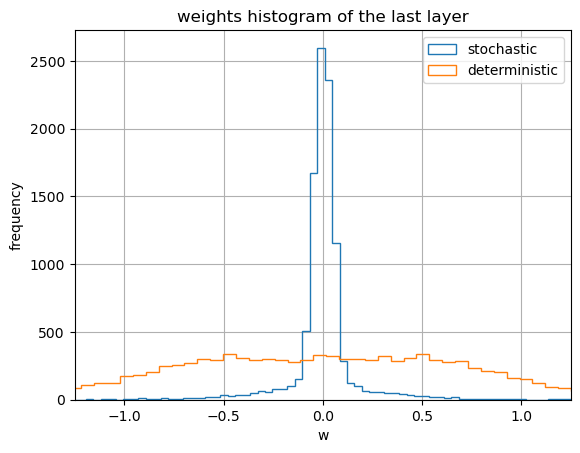

In [17]:
s_folder = r'./stochastic_1_1'
net_fn = os.path.join(s_folder, 'binarized_net.pt')
net_stochastic = BinaryNet()
net_stochastic.load_state_dict(torch.load(net_fn)) # load network trained by stochastic binarization
print("Skipped Training. Loaded network trained by stochastic binarization with binarizer being 1 and -1")
first_layer_stochastic_weight = net_stochastic.classifiers[2].weight.detach()
first_layer_stochastic_weight = first_layer_stochastic_weight.reshape(1, -1)
first_layer_stochastic_weight, indices = torch.sort(first_layer_stochastic_weight)

d_folder = r'./deterministic_1_1'
net_fn = os.path.join(d_folder, 'binarized_net.pt')
net_deterministic = BinaryNet()
net_deterministic.load_state_dict(torch.load(net_fn)) # load network trained by stochastic binarization
print("Skipped Training. Loaded network trained by deterministic binarization with binarizer being 1 and -1")
first_layer_deterministic_weight = net_deterministic.classifiers[2].weight.detach()
first_layer_deterministic_weight = first_layer_deterministic_weight.reshape(1, -1)
first_layer_deterministic_weight, indices = torch.sort(first_layer_deterministic_weight)

fig, ax = plt.subplots()
ax.hist(first_layer_stochastic_weight, bins=100, histtype="step", label="stochastic")
ax.hist(first_layer_deterministic_weight, bins=100, histtype="step", label="deterministic")
ax.legend()
ax.grid()
ax.set_xlim(-1.25, 1.25)
ax.set_xlabel('w')
ax.set_ylabel('frequency')
ax.set_title('weights histogram of the last layer')
fig.savefig('./figure/weights histogram.png')

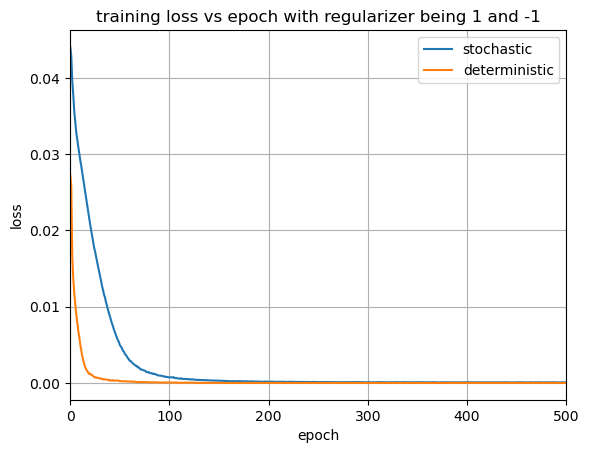

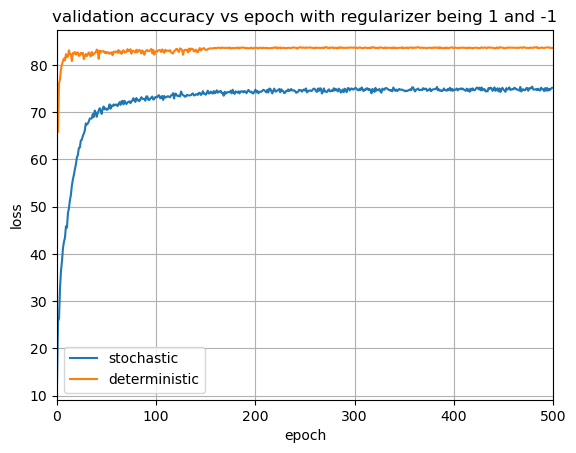

In [18]:
with open('./stochastic_1_1/train_loss_and_validation_accuracy.csv', 'r', encoding='UTF8') as f:
    csv_reader = csv.reader(f)
    stochastic_1_1 = list(csv_reader)
train_loss_of_every_epoch_stochastic_1_1 = stochastic_1_1[0]
train_loss_of_every_epoch_stochastic_1_1 = [float(e) for e in train_loss_of_every_epoch_stochastic_1_1]
validation_accuracy_of_every_epoch_stochastic_1_1 = stochastic_1_1[2]
validation_accuracy_of_every_epoch_stochastic_1_1 = [float(e) for e in validation_accuracy_of_every_epoch_stochastic_1_1]

with open('./deterministic_1_1/train_loss_and_validation_accuracy.csv', 'r', encoding='UTF8') as f:
    csv_reader = csv.reader(f)
    deterministic_1_1 = list(csv_reader)
train_loss_of_every_epoch_deterministic_1_1 = deterministic_1_1[0]
train_loss_of_every_epoch_deterministic_1_1 = [float(e) for e in train_loss_of_every_epoch_deterministic_1_1]
validation_accuracy_of_every_epoch_deterministic_1_1 = deterministic_1_1[2]
validation_accuracy_of_every_epoch_deterministic_1_1 = [float(e) for e in validation_accuracy_of_every_epoch_deterministic_1_1]

fig, ax = plt.subplots()
ax.plot(train_loss_of_every_epoch_stochastic_1_1, label="stochastic")
ax.plot(train_loss_of_every_epoch_deterministic_1_1, label="deterministic")
ax.legend()
ax.grid()
ax.set_xlim(0, 500)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('training loss vs epoch with regularizer being 1 and -1')
fig.savefig('./figure/1_1_train_loss_vs_epoch.png')

fig, ax = plt.subplots()
ax.plot(validation_accuracy_of_every_epoch_stochastic_1_1, label="stochastic")
ax.plot(validation_accuracy_of_every_epoch_deterministic_1_1, label="deterministic")
ax.legend()
ax.grid()
ax.set_xlim(0, 500)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('validation accuracy vs epoch with regularizer being 1 and -1')
fig.savefig('./figure/1_1_validation_accuracy_vs_epoch.png')

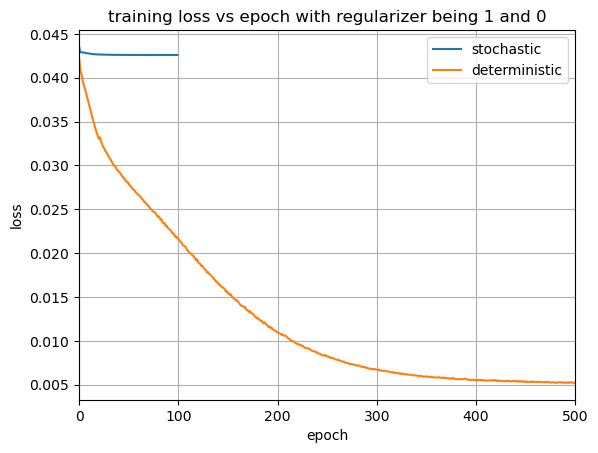

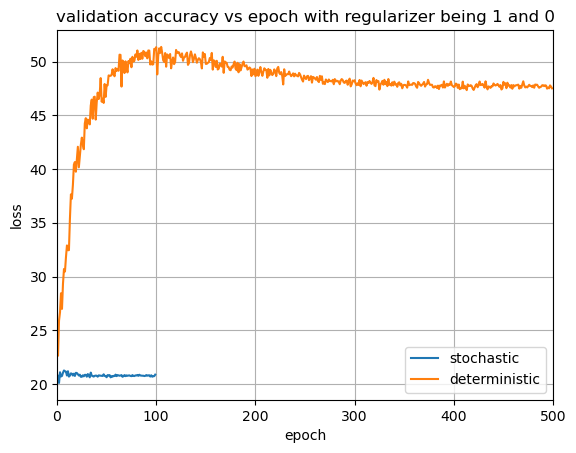

In [19]:
with open('./stochastic_1_0/train_loss_and_validation_accuracy.csv', 'r', encoding='UTF8') as f:
    csv_reader = csv.reader(f)
    stochastic_1_0 = list(csv_reader)
train_loss_of_every_epoch_stochastic_1_0 = stochastic_1_0[0]
train_loss_of_every_epoch_stochastic_1_0 = [float(e) for e in train_loss_of_every_epoch_stochastic_1_0]
validation_accuracy_of_every_epoch_stochastic_1_0 = stochastic_1_0[2]
validation_accuracy_of_every_epoch_stochastic_1_0 = [float(e) for e in validation_accuracy_of_every_epoch_stochastic_1_0]

with open('./deterministic_1_0/train_loss_and_validation_accuracy.csv', 'r', encoding='UTF8') as f:
    csv_reader = csv.reader(f)
    deterministic_1_0 = list(csv_reader)
train_loss_of_every_epoch_deterministic_1_0 = deterministic_1_0[0]
train_loss_of_every_epoch_deterministic_1_0 = [float(e) for e in train_loss_of_every_epoch_deterministic_1_0]
validation_accuracy_of_every_epoch_deterministic_1_0 = deterministic_1_0[2]
validation_accuracy_of_every_epoch_deterministic_1_0 = [float(e) for e in validation_accuracy_of_every_epoch_deterministic_1_0]

fig, ax = plt.subplots()
ax.plot(train_loss_of_every_epoch_stochastic_1_0, label="stochastic")
ax.plot(train_loss_of_every_epoch_deterministic_1_0, label="deterministic")
ax.legend()
ax.grid()
ax.set_xlim(0, 500)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('training loss vs epoch with regularizer being 1 and 0')
fig.savefig('./figure/1_0_train_loss_vs_epoch.png')

fig, ax = plt.subplots()
ax.plot(validation_accuracy_of_every_epoch_stochastic_1_0, label="stochastic")
ax.plot(validation_accuracy_of_every_epoch_deterministic_1_0, label="deterministic")
ax.legend()
ax.grid()
ax.set_xlim(0, 500)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('validation accuracy vs epoch with regularizer being 1 and 0')
fig.savefig('./figure/1_0_validation_accuracy_vs_epoch.png')

The next part is to train the binary network with SVHN. SVHN is quite a large dataset so the network is only trained for 30 epochs to show that our implemented network can work on multiple datasets.

In [14]:
transform = transforms.Compose(
  [transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset2 = torchvision.datasets.SVHN(root='./../svhn', split="train", download=True, transform=transform)
trainloader2 = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset2 = torchvision.datasets.SVHN(root='./../svhn', split="test", download=True, transform=transform)
testloader2 = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)
classes2 = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Using downloaded and verified file: ./../svhn\train_32x32.mat
Using downloaded and verified file: ./../svhn\test_32x32.mat


In [15]:
criterion = nn.CrossEntropyLoss()
num_epochs = 30
LR_start = 3 * 1e-3
LR_fin = 2 * 1e-6
LR_decay = (LR_fin/LR_start)**(1./500)
LR = LR_start
net2 = BinaryNet()
print("num_epochs:", num_epochs, " learning_rate_start:", LR_start, " learning_rate_final:", LR_fin, " learning_rate_decay:", LR_decay)
print(net2)
net2 = net2.to(device)

num_epochs: 30  learning_rate_start: 0.003  learning_rate_final: 2e-06  learning_rate_decay: 0.9854800059995851
BinaryNet(
  (features): Sequential(
    (0): binConv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): binConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): binConv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (9): ReLU()
    (10): binConv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2

In [16]:
train_loss_of_every_epoch = []
validation_accuracy_of_every_epoch = []

for epoch in range(num_epochs):
  running_loss = 0.0
  running_num = 0
  optimizer = torch.optim.Adam(net2.parameters(), lr=LR)

  for i, data in enumerate(trainloader2, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = net2(inputs) # forward

    loss = criterion(outputs, labels) # calculate loss.
    loss.backward() # Use binarized weights to compute derivatives to speed up.

    for p in list(net2.parameters()):
      if hasattr(p,'org'):
        p.data.copy_(p.org)

    optimizer.step() # Use derivatives to update original weights rather than binarized weights.

    for p in list(net2.parameters()):
      if hasattr(p,'org'):
        p.org.copy_(p.data.clamp_(-1,1))

    running_loss += loss.item()
    running_num += batch_size
      
  print("eopch: ", epoch+1, ", learning rate: ", LR)
  LR = LR * LR_decay
    
  print("eopch: ", epoch+1, ", training loss: ", running_loss / running_num)
  train_loss_of_every_epoch.append(running_loss / running_num)

  top1_acc = validate_model(net2, testloader2)
  print("eopch: ", epoch+1, ", accuracy: ", top1_acc)
  validation_accuracy_of_every_epoch.append(top1_acc.detach().cpu().numpy())

print('Finished Training.')

eopch:  1 , learning rate:  0.003
eopch:  1 , training loss:  0.04367655420780182
eopch:  1 , accuracy:  tensor(11.1800, device='cuda:0', dtype=torch.float64)
eopch:  2 , learning rate:  0.002956440017998755
eopch:  2 , training loss:  0.04274882150173187
eopch:  2 , accuracy:  tensor(25.1500, device='cuda:0', dtype=torch.float64)
eopch:  3 , learning rate:  0.0029135125266748266
eopch:  3 , training loss:  0.03958813667058945
eopch:  3 , accuracy:  tensor(25.1100, device='cuda:0', dtype=torch.float64)
eopch:  4 , learning rate:  0.0028712083422673743
eopch:  4 , training loss:  0.03817911155462265
eopch:  4 , accuracy:  tensor(30.8000, device='cuda:0', dtype=torch.float64)
eopch:  5 , learning rate:  0.0028295184143637105
eopch:  5 , training loss:  0.03646879189491272
eopch:  5 , accuracy:  tensor(35.4000, device='cuda:0', dtype=torch.float64)
eopch:  6 , learning rate:  0.002788433823963086
eopch:  6 , training loss:  0.03471695965766907
eopch:  6 , accuracy:  tensor(38.0100, device

Log:

2022.11.21：
1. loss function暂时没用原文那个，现在用的交叉熵，原文那个在代码里注释掉了因为我不确定我用的语法对不对。如果要换成原文那个在training那块还要做点改动，交叉熵是outputs的10个value都留着，原文那个只留值最大的index。但是诸如optimizer和learning rate decay和网络结构都已经和原文保持一致了
2. 我没训练完，但看着是好像没啥问题，也没加validate，没看accuracy
3. 现在的网络和num_epoch都是按原文的来的，但网络的kernel数太多了而且epoch也太多，不知道训练需要多长时间，可以加上validate后先削点层数训练一下看看正确性
4. 没加time.time()
5. 还有一些比如说训练时候的print之类的小地方可以完善一下

2022.11.22:
* Train network using GPU if GPU is available
* Plot training loss
* save model and figures to the related google drive

2022.11.23
* Remove more than half computation complexity to check the effect. After training the model for more than 60 epochs, I find the training loss does not decrease obviously after first few epochs.

2022.11.24
* paper提供的pytorch代码里虽然bias=True，但是在他定义的那个binary卷积层里调用conv2d的那一步的bias对应的参数直接给了个None，也就是说作者对bias的声明是无效的。尝试了把那个None改为True并加上bias相关代码，精度没什么变化。
* 在update parameter的时候加上了clip，精度没什么变化。
* 将网络简化至如上面所用，相比原网络精度没有下降，都是40%左右。
* 小网络不用binarization前几个epoch的精度就有77%+，相比binarization仍然差不少。
* 
* 按照paper给的pytorch代码加入了weight.org这一attribute，小网络精度在前10个epoch提升到70%左右，还没细想其中原因。

2022.11.25
* 干得漂亮！
* 我读了下代码，加了weight.org后精度提升是因为这才是原文的算法。11.24之前我们实现的代码在反向传播中使用的仍然是binarized weight，然后在下一次前向传播中binarized后weight等于基本没有更新。而这个版本的代码用self.weight.org来存储float-point-version-weight，反向传播时使用的是float-point-version-weight，前向传播时使用的是bianry-weight。
* 修改batch size为50（原文使用50），发现更大的batch size一个epoch训练时间更少，但相同的epoch下比更小的batch size得到的accuracy更差。想来多跑一些epoch是一样的
* Accuracy在70%之后停止增长，不论batch size为50还是4，可能这个小型版本的网络的能力极限就到这了

2022.11.26
* 完整网络训练500 epochs最终精度78%，怀疑是stochastic binarization的原因
* 修改stochastic binarization为deterministic binarization，相同epoch下精度明显提高，建议只采用deterministic binarization
* 发现原来的LR并未更新，改正

2022.11.28
* 按照TA要求要能在两个数据库上运行，于是增加训练SVHN数据库的代码。SVHN的图片尺寸和cifar10一样所以不需任何处理。

2022.11.29
* I set the program to be the deterministic binarization with weight of +1 and -1. To prevent making mistakes, I duplicate a new file to test the deterministic binarization with weight of +1 and 0. Check the new file at: https://colab.research.google.com/drive/1LPvHCNKY2W6jUrcNz7WqgH3OFaCMn7mM?usp=sharing

To-Do
* Reproduce the CIFAR-10 part of the table
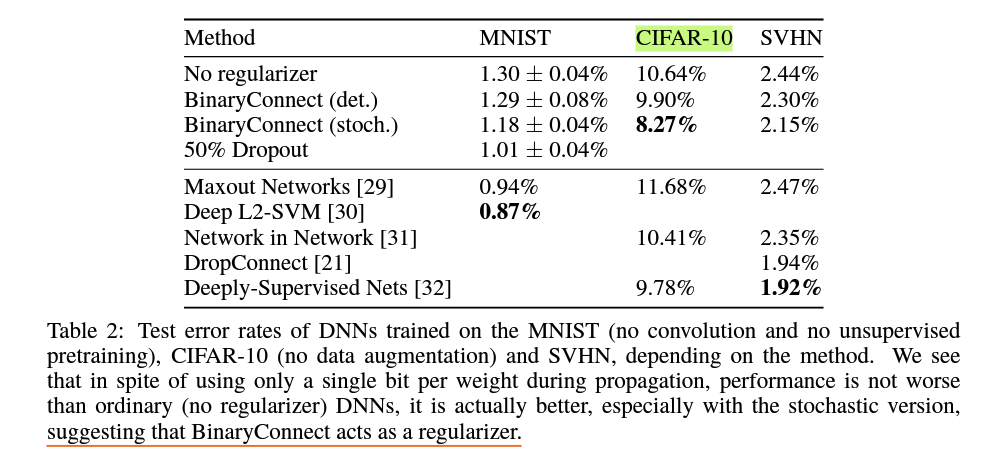

* Reproduce the figure but compare the -1/+1 and 0/+1 weights distribution (I don't think we need care about the difference between deterministic and stochatistic binarization).
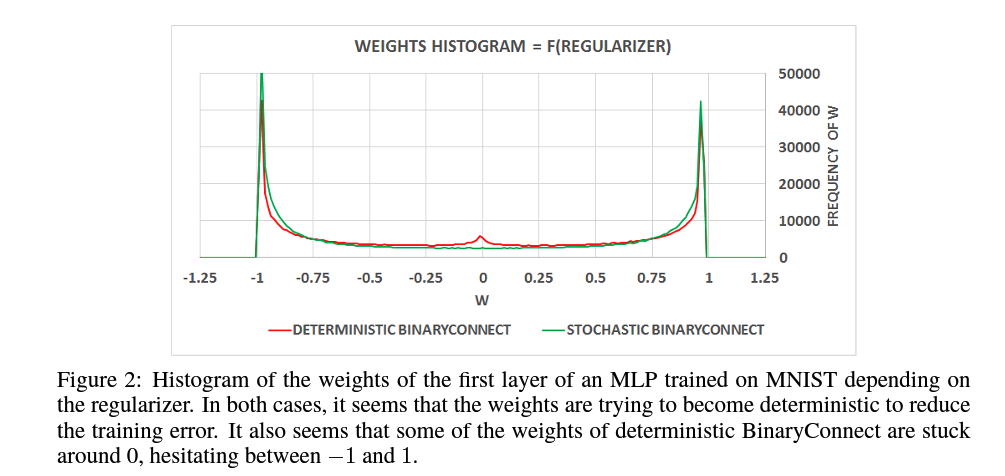

* Reproduce the figure but compare the training loss and validationn error of no-regulizer, -1/+1, and 0/+1 respectively.
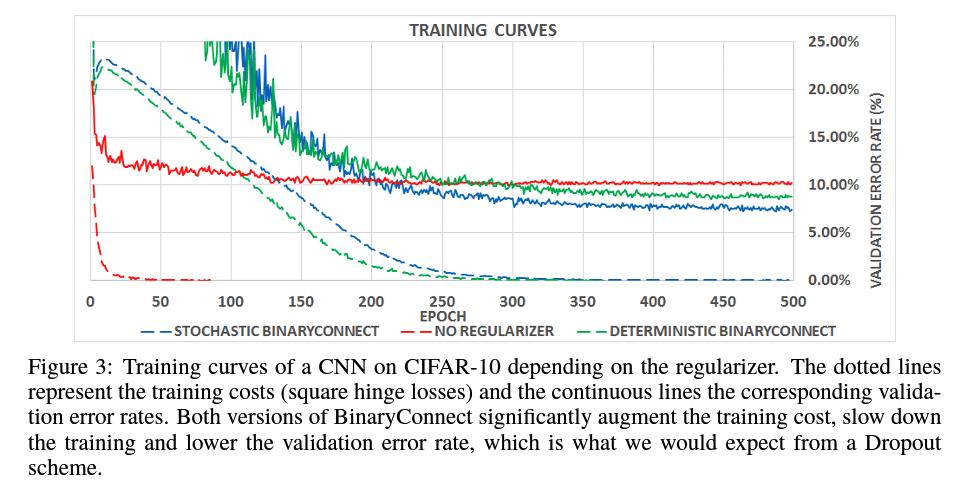

